In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import glob
import seaborn as sns

### CARGANDO TRANSFERENCIAS DIFERIDAS

In [2]:
##CARGANDO TRANSFERENCIAS

path = "C:\\Users\\jloayzap\\Documents\\JLP\\ANALISIS_OPERACIONES\\TRANSFERENCIAS\\DIFERIDAS"

filenames = glob.glob(path + "\*.xlsx")
#print('File names:', filenames)
df_trans = pd.DataFrame()

for f in filenames:
    data = pd.read_excel(f, 'Hoja1', converters={'Número Unico de Operación':str})
    df_trans = df_trans.append(data)
    
df_trans['CCI_Destino_2'] = np.where(df_trans['CCI Destino'].str.len() == 20, df_trans['CCI Destino'], '0' + df_trans['CCI Destino'].astype(str))
df_trans["ANIO"] = df_trans['Fecha Presentación'].str[:4] 
df_trans["MES"] = df_trans['Fecha Presentación'].str[5:7]
df_trans['ANIOMES'] = df_trans['ANIO'].astype(str) + df_trans['MES'].astype(str)
df_trans["Importe Transferencia"] = df_trans.rename(columns={'Importe Transferencia':'IMPORTE'}, inplace = True)
df_trans['IMPORTE_FINAL'] = df_trans['IMPORTE'].astype(float)

In [3]:
df_trans.head()

,Transferencia,Fecha Presentación,Fecha Liquidación,Sesión,Moneda,IMPORTE,Comisión Interbancaria,Comisión Cliente,Comisión Rechazo Cliente,Itf Transferencia,...,Periodo Mes,Periodo Año,Tipo Pago Haberes,Unnamed: 63,CCI_Destino_2,ANIO,MES,ANIOMES,Importe Transferencia,IMPORTE_FINAL
0,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,19.55,5.0,0.0,0,0.0,...,3.0,2022.0,NaN,NaN,05430982020028950700,2022,04,202204,None,19.55
1,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,4.19,5.0,0.0,0,0.0,...,3.0,2022.0,NaN,NaN,05430982020028882909,2022,04,202204,None,4.19
2,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,71.22,5.0,0.0,0,0.0,...,3.0,2022.0,NaN,NaN,05430982020017267701,2022,04,202204,None,71.22
3,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,96.91,5.0,0.0,0,0.0,...,3.0,2022.0,NaN,NaN,05430982020017071208,2022,04,202204,None,96.91
4,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,140.00,0.0,0.0,0,0.0,...,NaN,NaN,NaN,NaN,05488881888000878937,2022,04,202204,None,140.00


### CARGANDO TRANSFERENCIAS INMEDIATAS

In [4]:
##CARGANDO TRANSFERENCIAS

path = "C:\\Users\\jloayzap\\Documents\\JLP\\ANALISIS_OPERACIONES\\TRANSFERENCIAS\\INMEDIATAS"

#IMPORTANDO ARCHIVO PAGO TC 2021, ENERO Y MARZO 2022
gen  = pd.read_csv("C:\\Users\\jloayzap\\Documents\\JLP\\ANALISIS_OPERACIONES\\TRANSFERENCIAS\\INMEDIATAS\\inmediatas_full.csv", sep=';',  chunksize=10000000,
                                usecols = ['Identificador_CCE', 'Proceso','Fecha', 'Tipo_de_Transferencia', 'Moneda', 'Importe','Estado', 'Tipo_Documento_Origen', 'Documento_Origen'], dtype = 'str', low_memory = True)

df = pd.concat((x.query("Tipo_de_Transferencia == 'Transfer. Ordinaria' & Estado == 'Aprobado'") for x in gen), ignore_index=True)

df.head()


,Identificador_CCE,Proceso,Fecha,Tipo_de_Transferencia,Moneda,Importe,Estado,Tipo_Documento_Origen,Documento_Origen
0,5906528,Entrada,2022-02-01,Transfer. Ordinaria,S/.,270.00,Aprobado,DNI,76849992
1,5906525,Entrada,2022-02-01,Transfer. Ordinaria,S/.,8.90,Aprobado,DNI,71291530
2,5906513,Entrada,2022-02-01,Transfer. Ordinaria,S/.,320.00,Aprobado,DNI,73189057
3,5906508,Entrada,2022-02-01,Transfer. Ordinaria,S/.,350.00,Aprobado,DNI,46254299
4,5906507,Entrada,2022-02-01,Transfer. Ordinaria,S/.,40.00,Aprobado,DNI,76131328


__INGENIERÍA DE DATOS TRANSFERENCIAS INMEDIATAS__

In [5]:
df["ANIO"] = df['Fecha'].str[:4] 
df["MES"] = df['Fecha'].str[5:7]
df['ANIOMES'] = df['ANIO'].astype(str) + df['MES'].astype(str)

# df["Importe"] = df.rename(columns={'Importe':'IMPORTE'}, inplace = True)
df['MONTO_2'] = df['Importe']
df['MONTO_2'] = df['MONTO_2'].str.replace(',','')
df['IMPORTE'] = pd.to_numeric(df['MONTO_2'],errors='coerce')

df["Tipo_Documento_Origen"] = df.rename(columns={'Tipo_Documento_Origen':'TIPODOCUMENTO'}, inplace = True)
df["Documento_Origen"] = df.rename(columns={'Documento_Origen':'NUMERODOCUMENTO'}, inplace = True)
df['IMPORTE_FINAL'] = df['IMPORTE'].astype(float)

In [6]:
##PARTICIONANDO BASE INMEDIATA
#ENTRADAS
df_trans_inmediata_ent = df[df.Proceso.isin(['Entrada','ENTRADA'])]
# df_trans_inmediata_ent = df_trans_inmediata_ent[df_trans_inmediata_ent.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]
df_trans_inmediata_ent = df_trans_inmediata_ent[df_trans_inmediata_ent['ANIOMES'].str[:4] == '2022' ]

#SALIDAS
df_trans_inmediata_sal = df[df.Proceso.isin(['Salida','SALIDA'])]
# df_trans_inmediata_sal = df_trans_inmediata_sal[df_trans_inmediata_sal.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]
df_trans_inmediata_sal = df_trans_inmediata_sal[df_trans_inmediata_sal['ANIOMES'].str[:4] == '2022' ]

__INGENIERÍA DE DATOS TRANSFERENCIAS DIFERIDAS__

In [7]:
##PARTICIONANDO BASE DIFERIDA
#ENTRADAS
df_trans_ent = df_trans[df_trans['Transferencia'] == 'E - ENTR']
df_trans_ent = df_trans_ent[df_trans_ent.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]
df_trans_ent = df_trans_ent[df_trans_ent['ANIOMES'].str[:4] == '2022' ]

#SALIDAS
df_trans_sal = df_trans[df_trans['Transferencia'] == 'S - SALID']
df_trans_sal = df_trans_sal[df_trans_sal.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]
df_trans_sal = df_trans_sal[df_trans_sal['ANIOMES'].str[:4] == '2022' ]

In [8]:
##CARGANDO SALDOS
df_saldos = pd.read_csv("C:\\Users\\jloayzap\\Documents\\JLP\\SALDOS_MOVIMIENTO\\SALDOS\\Saldos.csv", sep = ";", converters={'NROCUENTA':str, 'NUMERODOCUMENTO':str, 'CCICODE':str})

C:\Users\jloayzap\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (23,29,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### TRABAJANDO CON TRANSFERENCIAS ENTRADAS

In [9]:
#Obteniendo DNI Clientes
##OBTENIENDO DNI CIENTE DESDE BASE DE SALDOS
df_trans_ent = df_trans_ent.merge(df_saldos[['CCICODE', 'TIPODOCUMENTO', 'NUMERODOCUMENTO']], left_on ='CCI_Destino_2', right_on='CCICODE', how='left')
df_trans_ent.head()

,Transferencia,Fecha Presentación,Fecha Liquidación,Sesión,Moneda,IMPORTE,Comisión Interbancaria,Comisión Cliente,Comisión Rechazo Cliente,Itf Transferencia,...,Unnamed: 63,CCI_Destino_2,ANIO,MES,ANIOMES,Importe Transferencia,IMPORTE_FINAL,CCICODE,TIPODOCUMENTO,NUMERODOCUMENTO
0,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,19.55,5.0,0.0,0,0.0,...,NaN,05430982020028950700,2022,04,202204,None,19.55,05430982020028950700,1.0,33262878
1,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,4.19,5.0,0.0,0,0.0,...,NaN,05430982020028882909,2022,04,202204,None,4.19,05430982020028882909,1.0,32892313
2,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,71.22,5.0,0.0,0,0.0,...,NaN,05430982020017267701,2022,04,202204,None,71.22,05430982020017267701,1.0,33263696
3,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,96.91,5.0,0.0,0,0.0,...,NaN,05430982020017071208,2022,04,202204,None,96.91,05430982020017071208,1.0,32987910
4,E - ENTR,2022-04-13,2022-04-13,1 - Turno Mañana,2 - Dólares Americanos,140.00,0.0,0.0,0,0.0,...,NaN,05488881888000878937,2022,04,202204,None,140.00,05488881888000878937,1.0,10139576


In [10]:
df_trans_ent['Moneda'] = df_trans_ent['Moneda'].str.replace('2 - Dólares Americanos','USD')
df_trans_ent['Moneda'] = df_trans_ent['Moneda'].str.replace('1 - Soles','PEN')
df_trans_sal['Moneda'] = df_trans_sal['Moneda'].str.replace('2 - Dólares Americanos','USD')
df_trans_sal['Moneda'] = df_trans_sal['Moneda'].str.replace('1 - Soles','PEN')


In [11]:
df_trans_inmediata_ent['Moneda'] = df_trans_inmediata_ent['Moneda'].str.replace('$','USD')
df_trans_inmediata_ent['Moneda'] = df_trans_inmediata_ent['Moneda'].str.replace('S/.','PEN')
df_trans_inmediata_sal['Moneda'] = df_trans_inmediata_sal['Moneda'].str.replace('$','USD')
df_trans_inmediata_sal['Moneda'] = df_trans_inmediata_sal['Moneda'].str.replace('S/.','PEN')

<ipython-input-11-9349e85d926a>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_trans_inmediata_ent['Moneda'] = df_trans_inmediata_ent['Moneda'].str.replace('$','USD')
<ipython-input-11-9349e85d926a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_trans_inmediata_ent['Moneda'] = df_trans_inmediata_ent['Moneda'].str.replace('S/.','PEN')
<ipython-input-11-9349e85d926a>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_trans_inmediata_sal['Moneda'] = df_trans_inmediata_sal['Moneda'].str.replace('$','USD')
<ipython-input-11-9349e85d926a>:4: FutureWarning: The default value of regex will change from True to False in a futur

In [12]:
#TRANS ENTRADAS
df_e1 =  df_trans_ent[['NUMERODOCUMENTO', 'ANIOMES', 'IMPORTE_FINAL', 'Moneda']]
df_e2 =  df_trans_inmediata_ent[['NUMERODOCUMENTO', 'ANIOMES', 'IMPORTE_FINAL', 'Moneda']]


# #TRANS SALIDAS
# df_s1 = df_trans_sal[['NUMERODOCUMENTO', 'ANIOMES', 'IMPORTE_FINAL', 'Moneda']]
# df_s2 = df_trans_inmediata_sal[['NUMERODOCUMENTO', 'ANIOMES', 'IMPORTE_FINAL', 'Moneda']]

df_trans_ent = pd.concat([df_e1,df_e2])
# df_trans_sal = pd.concat([df_s1,df_s2])

In [13]:
df_trans_ent.rename(columns={'IMPORTE_FINAL':'IMPORTE'}, inplace = True)

In [14]:
df_trans_ent.head()

,NUMERODOCUMENTO,ANIOMES,IMPORTE,Moneda
0,33262878,202204,19.55,USD
1,32892313,202204,4.19,USD
2,33263696,202204,71.22,USD
3,32987910,202204,96.91,USD
4,10139576,202204,140.00,USD


In [15]:
grupo = pd.DataFrame()
grupo = df_trans_ent.groupby(['NUMERODOCUMENTO', 'ANIOMES']).NUMERODOCUMENTO.size()
df_trans_ent_grupo = pd.DataFrame(grupo.reset_index(name='CUENTA_OP'))
df_trans_ent_grupo.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_ent_grupo['LLAVE'] = df_trans_ent_grupo['NUMERODOCUMENTO'].astype(str) + df_trans_ent_grupo['ANIOMES'].astype(str)

grupo = pd.DataFrame()
grupo = df_trans_ent.groupby(['NUMERODOCUMENTO', 'ANIOMES']).IMPORTE.sum()
df_trans_ent_sum = pd.DataFrame(grupo.reset_index(name='SUMA_OP'))
df_trans_ent_sum.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_ent_sum['LLAVE'] = df_trans_ent_sum['NUMERODOCUMENTO'].astype(str) + df_trans_ent_sum['ANIOMES'].astype(str)

df_trans_ent_grupo_sum = df_trans_ent_grupo.merge(df_trans_ent_sum.drop_duplicates(subset=['LLAVE'])[['LLAVE', 'SUMA_OP']], left_on ='LLAVE', right_on='LLAVE', how='inner')
df_trans_ent_grupo_sum.sort_values(['CUENTA_OP', 'SUMA_OP'], ascending=False)

,NUMERODOCUMENTO,ANIOMES,CUENTA_OP,LLAVE,SUMA_OP
157634,47398435,202203,225,47398435202203,31361.00
99334,42857956,202204,219,42857956202204,43800.00
36969,10643799,202204,201,10643799202204,68654.00
115255,44148915,202204,199,44148915202204,99150.00
141795,46209528,202204,174,46209528202204,85763.24
...,...,...,...,...,...
207311,75275911,202201,1,75275911202201,0.01
208034,75404175,202201,1,75404175202201,0.01
208452,75459614,202203,1,75459614202203,0.01
211082,76059119,202201,1,76059119202201,0.01


In [16]:
df_trans_ent_grupo_sum_unico = df_trans_ent_grupo_sum[df_trans_ent_grupo_sum['CUENTA_OP'] == 1]
df_trans_ent_grupo_sum_mul = df_trans_ent_grupo_sum[df_trans_ent_grupo_sum['CUENTA_OP'] > 1]

Validar 4 tipologías 
 - Transferencias entradas montos unicos
 - Transferencias entradas montos multiples
 - Transferencias salidas montos unicos
 - Transferencias salidas montos multiples     

**PARTICIANDO DATAFRAME SEGUN EL MES Y AÑO**
 - Utilizamos la función locals para generar dataframes dinamicos)

In [17]:
#Particionar Dataframe df_trans_ent_grupo_sum_unico
for i, (ID, subdf) in enumerate(df_trans_ent_grupo_sum_unico.groupby('ANIOMES'), 1):
    locals()[f'df{ID}'] = subdf

In [18]:
#Particionar Dataframe df_trans_ent_grupo_sum_mult
for i, (ID, subdf) in enumerate(df_trans_ent_grupo_sum_mul.groupby('ANIOMES'), 1):
    locals()[f'df_mult{ID}'] = subdf

**PRUEBA DE GENERACIÓN MULTIPLES DATAFRAME DE FRECUENCIAS**

In [19]:
##Generando multiples frecuencias

# import math

# #Creando lista con los grupos
# dataframes_valores_prueba = df_trans_ent_grupo_sum_unico.ANIOMES.unique()

# for i in dataframes_valores_prueba:
#     #print(locals()[f'df{i}']['SUMA_OP'])
#     #print ([f'df{i}'])
    
#     pd.set_option('precision', 2)
#     datos = locals()[f'df{i}']['SUMA_OP'].astype(float)

#     # Cálculo del número de intervalos
#     # Si la parte entera de k es un número impar, redondeamos a la baja
#     k = 1 + 3.322 * math.log10(len(datos))
#     numero = int(k)
#     if numero % 2 == 0:
#         periodos = math.ceil(k)
#     else:
#         periodos = int(k)

#     inf = datos.min()        # Limite inferior del primer intervalo
#     dif = datos.max()
#     sup = datos.max() + 1    # Limite superior del último intervalo

#     intervals = pd.interval_range(
#         start=inf,
#         end=sup,
#         periods=k,
#         name="Intervalo",
#         closed="left")

#     locals()[f'df_frec_{i}'] = pd.DataFrame(index=intervals)
#     locals()[f'df_frec_{i}']["FreqAbs"] = pd.cut(datos, bins=locals()[f'df_frec_{i}'].index).value_counts()
#     locals()[f'df_frec_{i}']["Marca"]  = locals()[f'df_frec_{i}'].index.mid

# #Imprimir Dataframe particionado distribución
# from IPython.display import display

# for i in dataframes_valores_prueba:
#     print (i)
#     display(locals()[f'df_frec_{i}'])

***PRUEBA MANUAL TABLA + HISTOGRAMA***

In [20]:
# ###PRUEBA MANUAL

# import math
# import matplotlib.pyplot as plt
# from matplotlib.ticker import StrMethodFormatter

# ####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
# datos = df202108['SUMA_OP'].astype(float)

# k = int(1 + 3.322 * math.log10(len(datos)))

# inf = datos.min()        # Limite inferior del primer intervalo
# dif = datos.max()
# sup = datos.max() + 1    # Limite superior del último intervalo

# intervals = pd.interval_range(
#     start=inf,
#     end=sup,
#     periods=k,
#     name="Intervalo",
#     closed="left")

# lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

# ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
# df202108_lim_excluir = df202108[df202108['SUMA_OP'] >= lim_excluir]

# ###OBTENIENDO LOS K 
# k = int(1 + 3.322 * math.log10(len(df202108_lim_excluir['SUMA_OP'].astype(float))))

# ###GENERANDO EL HISTOGRAMA
# ax = df202108_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

# ax = ax[0]
# for x in ax:

#     # Despine
#     x.spines['right'].set_visible(True)
#     x.spines['top'].set_visible(True)
#     x.spines['left'].set_visible(True)

#     # Switch off ticks
#     x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#     # Draw horizontal axis lines
#     vals = x.get_yticks()
#     for tick in vals:
#         x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

#     # Remove title
#     x.set_title("")

#     # Set x-axis label
#     x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

#     # Set y-axis label
#     x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

#     # Format y-axis label
#     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# ## Imprimiendo Dataframe frecuencias
# pd.set_option('precision', 2)
# datos2 = df202108_lim_excluir['SUMA_OP'].astype(float)

#     # Cálculo del número de intervalos
#     # Si la parte entera de k es un número impar, redondeamos a la baja
# k = 1 + 3.322 * math.log10(len(datos2))
# numero = int(k)
# if numero % 2 == 0:
#     periodos = math.ceil(k)
# else:
#     periodos = int(k)

# inf = datos2.min()        # Limite inferior del primer intervalo
# dif = datos2.max()
# sup = datos2.max() + 1    # Limite superior del último intervalo

# intervals = pd.interval_range(
#     start=inf,
#     end=sup,
#     periods=k,
#     name="Intervalo",
#     closed="left")

# df202108_lim_excluir_frec = pd.DataFrame(index=intervals)
# df202108_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df202108_lim_excluir_frec.index).value_counts()
# df202108_lim_excluir_frec["Marca"]  = df202108_lim_excluir_frec.index.mid

# display(df202108_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO CONSOLLIDADO DE TRANSFERENCIAS OPERACIONES UNICAS***

,FreqAbs,Marca
Intervalo,,
"[24900.0, 57825.083333333336)",1127,41362.54
"[57825.083333333336, 90750.16666666667)",393,74287.62
"[90750.16666666667, 123675.25)",364,107212.71
"[123675.25, 156600.33333333334)",84,140137.79
"[156600.33333333334, 189525.4166666667)",36,173062.88
"[189525.4166666667, 222450.5)",46,205987.96
"[222450.5, 255375.58333333334)",20,238913.04
"[255375.58333333334, 288300.6666666667)",4,271838.12
"[288300.6666666667, 321225.75)",14,304763.21


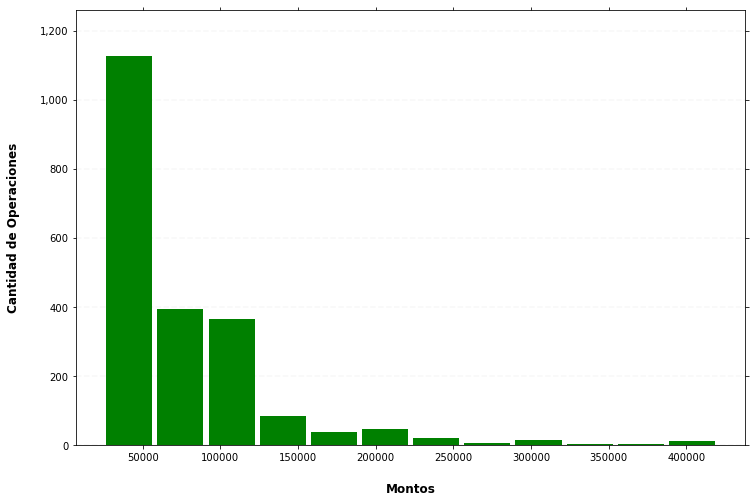

In [21]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_ent_grupo_sum_unico['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_ent_grupo_sum_unico_lim_excluir = df_trans_ent_grupo_sum_unico[df_trans_ent_grupo_sum_unico['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_ent_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_ent_grupo_sum_unico_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_ent_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_ent_grupo_sum_unico_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_ent_grupo_sum_unico_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_ent_grupo_sum_unico_lim_excluir_frec.index).value_counts()
df_trans_ent_grupo_sum_unico_lim_excluir_frec["Marca"]  = df_trans_ent_grupo_sum_unico_lim_excluir_frec.index.mid

display(df_trans_ent_grupo_sum_unico_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS OPERACIONES UNICAS***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_ent_grupo_sum_unico.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_{i}_excluir'] = locals()[f'df{i}'][locals()[f'df{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_{i}_frec_excluir']["Marca"]  = locals()[f'df_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_{i}_frec_excluir'])

In [23]:
df_trans_ent_grupo_sum_mul = df_trans_ent_grupo_sum_mul[df_trans_ent_grupo_sum_mul['SUMA_OP'] <  1407406.2685714287]

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO CONSOLLIDADO DE TRANSFERENCIAS OPERACIONES MULTIPLES***

,FreqAbs,Marca
Intervalo,,
"[58942.57, 144493.33636363636)",959,101717.95
"[144493.33636363636, 230044.10272727275)",155,187268.72
"[230044.10272727275, 315594.86909090914)",54,272819.49
"[315594.86909090914, 401145.6354545455)",15,358370.25
"[401145.6354545455, 486696.40181818185)",8,443921.02
"[486696.40181818185, 572247.1681818182)",10,529471.79
"[572247.1681818182, 657797.9345454546)",7,615022.55
"[657797.9345454546, 743348.7009090909)",7,700573.32
"[743348.7009090909, 828899.4672727273)",1,786124.08


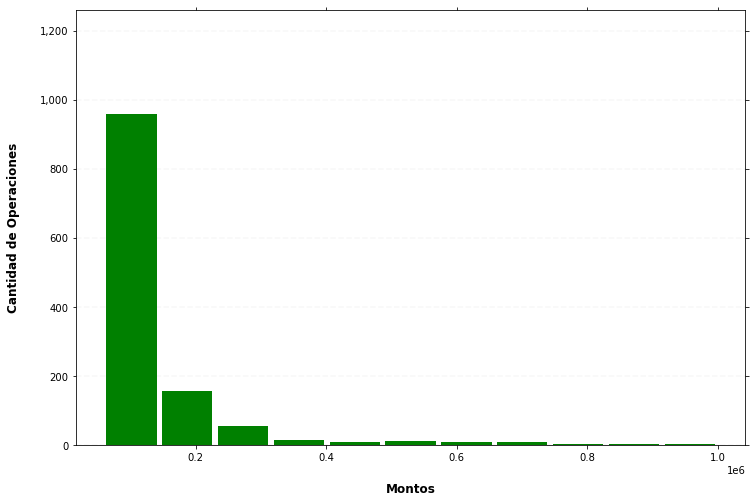

In [24]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

pd.options.display.float_format = '{:.2f}'.format
####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_ent_grupo_sum_mul['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_ent_grupo_sum_mul_lim_excluir = df_trans_ent_grupo_sum_mul[df_trans_ent_grupo_sum_mul['SUMA_OP'] >= lim_excluir]

#QUITANDO OUTLIER 3424317.8742857142
df_trans_ent_grupo_sum_mul_lim_excluir = df_trans_ent_grupo_sum_mul_lim_excluir[df_trans_ent_grupo_sum_mul_lim_excluir['SUMA_OP'] < 1407406.2685714287]


###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_ent_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_ent_grupo_sum_mul_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_ent_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_ent_grupo_sum_mul_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_ent_grupo_sum_mul_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_ent_grupo_sum_mul_lim_excluir_frec.index).value_counts()
df_trans_ent_grupo_sum_mul_lim_excluir_frec["Marca"]  = df_trans_ent_grupo_sum_mul_lim_excluir_frec.index.mid

display(df_trans_ent_grupo_sum_mul_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS OPERACIONES MULTIPLES***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
pd.options.display.float_format = '{:.2f}'.format

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_ent_grupo_sum_mul.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df_mult{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df_mult{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_mul_{i}_excluir'] = locals()[f'df_mult{i}'][locals()[f'df_mult{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_mul_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_mul_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_mul_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_mul_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_mul_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_mul_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_mul_{i}_frec_excluir']["Marca"]  = locals()[f'df_mul_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_mul_{i}_frec_excluir'])

### TRANSFERENCIAS SALIDAS 

****TRABAJANDO CON TRANSFERENCIAS SALIDAS****

In [26]:
df_trans_sal['NUMERODOCUMENTO'] = df_trans_sal['Número Doc. Origen'] 

In [27]:
#TRANS SALIDAS
df_s1 = df_trans_sal[['NUMERODOCUMENTO', 'ANIOMES', 'IMPORTE_FINAL', 'Moneda']]
df_s2 = df_trans_inmediata_sal[['NUMERODOCUMENTO', 'ANIOMES', 'IMPORTE_FINAL', 'Moneda']]

df_trans_ent = pd.concat([df_e1,df_e2])
df_trans_sal = pd.concat([df_s1,df_s2])

In [28]:
df_trans_sal.rename(columns={'IMPORTE_FINAL':'IMPORTE'}, inplace = True)

In [29]:
df_trans_sal.head()

,NUMERODOCUMENTO,ANIOMES,IMPORTE,Moneda
61670,72702148,202204,180.00,PEN
61671,40787323,202204,50.00,PEN
61672,46017213,202204,250.00,PEN
61674,42198001,202204,700.00,PEN
61676,46220671,202204,200.00,PEN


In [30]:
grupo = pd.DataFrame()
grupo = df_trans_sal.groupby(['NUMERODOCUMENTO', 'ANIOMES']).NUMERODOCUMENTO.size()
df_trans_sal_grupo = pd.DataFrame(grupo.reset_index(name='CUENTA_OP'))
df_trans_sal_grupo.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_sal_grupo['LLAVE'] = df_trans_sal_grupo['NUMERODOCUMENTO'].astype(str) + df_trans_sal_grupo['ANIOMES'].astype(str)

grupo = pd.DataFrame()
grupo = df_trans_sal.groupby(['NUMERODOCUMENTO', 'ANIOMES']).IMPORTE.sum()
df_trans_sal_sum = pd.DataFrame(grupo.reset_index(name='SUMA_OP'))
df_trans_sal_sum.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_sal_sum['LLAVE'] = df_trans_sal_sum['NUMERODOCUMENTO'].astype(str) + df_trans_sal_sum['ANIOMES'].astype(str)

df_trans_sal_grupo_sum = df_trans_sal_grupo.merge(df_trans_sal_sum.drop_duplicates(subset=['LLAVE'])[['LLAVE', 'SUMA_OP']], left_on ='LLAVE', right_on='LLAVE', how='inner')
df_trans_sal_grupo_sum.sort_values(['CUENTA_OP', 'SUMA_OP'], ascending=False)

,NUMERODOCUMENTO,ANIOMES,CUENTA_OP,LLAVE,SUMA_OP
8901,11111111.00,202202,702,11111111.0202202,333725.54
99220,10490353,202204,234,10490353202204,128056.00
8900,11111111.00,202201,224,11111111.0202201,81197.94
99218,10490310,202204,177,10490310202204,162173.00
191754,46948481,202203,149,46948481202203,391210.00
...,...,...,...,...,...
78799,002982554,202201,1,002982554202201,0.30
207469,48220715,202204,1,48220715202204,0.28
144385,42843361,202203,1,42843361202203,0.20
98084,10325500,202204,1,10325500202204,0.18


In [31]:
df_trans[df_trans['Número Doc. Origen'] == '10490353']

,Transferencia,Fecha Presentación,Fecha Liquidación,Sesión,Moneda,IMPORTE,Comisión Interbancaria,Comisión Cliente,Comisión Rechazo Cliente,Itf Transferencia,...,Periodo Mes,Periodo Año,Tipo Pago Haberes,Unnamed: 63,CCI_Destino_2,ANIO,MES,ANIOMES,Importe Transferencia,IMPORTE_FINAL


In [32]:
df_trans_sal_grupo_sum_unico = df_trans_sal_grupo_sum[df_trans_sal_grupo_sum['CUENTA_OP'] == 1]
df_trans_sal_grupo_sum_mul = df_trans_sal_grupo_sum[df_trans_sal_grupo_sum['CUENTA_OP'] > 1]

**PARTICIANDO DATAFRAME SEGUN EL MES Y AÑO**
 - Utilizamos la función locals para generar dataframes dinamicos)

In [33]:
#Particionar Dataframe df_trans_ent_grupo_sum_unico
for i, (ID, subdf) in enumerate(df_trans_sal_grupo_sum_unico.groupby('ANIOMES'), 1):
    locals()[f'df_sal_{ID}'] = subdf

#Particionar Dataframe df_trans_ent_grupo_sum_mult
for i, (ID, subdf) in enumerate(df_trans_sal_grupo_sum_mul.groupby('ANIOMES'), 1):
    locals()[f'df_sal_mult{ID}'] = subdf

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO CONSOLLIDADO DE TRANSFERENCIAS SALIDAS OPERACIONES UNICAS***

HISTOGRAMA CON TODAS PARTICIONES

In [34]:
## Imprimiendo Dataframe frecuencias
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

pd.set_option('precision', 2)
datos2 = df_trans_sal_grupo_sum_unico['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_sal_grupo_sum_unico_frec = pd.DataFrame(index=intervals)
df_trans_sal_grupo_sum_unico_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_sal_grupo_sum_unico_frec.index).value_counts()
df_trans_sal_grupo_sum_unico_frec["Marca"]  = df_trans_sal_grupo_sum_unico_frec.index.mid

display(df_trans_sal_grupo_sum_unico_frec)

,FreqAbs,Marca
Intervalo,,
"[0.13, 6666.845)",125926,3333.49
"[6666.845, 13333.56)",10427,10000.20
"[13333.56, 20000.275)",4457,16666.92
"[20000.275, 26666.99)",1515,23333.63
"[26666.99, 33333.704999999994)",1269,30000.35
"[33333.704999999994, 40000.42)",484,36667.06
"[40000.42, 46667.135)",222,43333.78
"[46667.135, 53333.85)",174,50000.49
"[53333.85, 60000.564999999995)",99,56667.21


HISTOGRAMA EXCLUYENDO PRIMERA PARTICIÓN 

,FreqAbs,Marca
Intervalo,,
"[6668.0, 14223.533333333333)",11146,10445.77
"[14223.533333333333, 21779.066666666666)",4172,18001.30
"[21779.066666666666, 29334.600000000002)",1563,25556.83
"[29334.600000000002, 36890.13333333333)",1039,33112.37
"[36890.13333333333, 44445.66666666667)",395,40667.90
"[44445.66666666667, 52001.200000000004)",218,48223.43
"[52001.200000000004, 59556.73333333334)",92,55778.97
"[59556.73333333334, 67112.26666666666)",68,63334.50
"[67112.26666666666, 74667.8)",46,70890.03


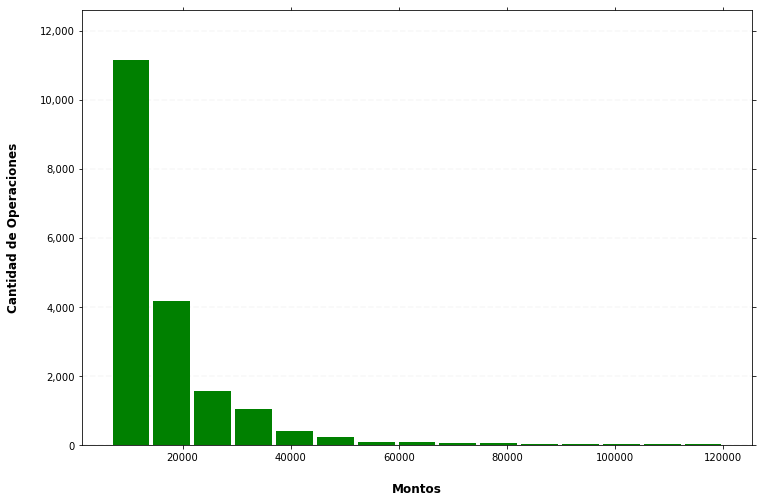

In [35]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_sal_grupo_sum_unico['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_sal_grupo_sum_unico_lim_excluir = df_trans_sal_grupo_sum_unico[df_trans_sal_grupo_sum_unico['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_sal_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_sal_grupo_sum_unico_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_sal_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_sal_grupo_sum_unico_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_sal_grupo_sum_unico_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_sal_grupo_sum_unico_lim_excluir_frec.index).value_counts()
df_trans_sal_grupo_sum_unico_lim_excluir_frec["Marca"]  = df_trans_sal_grupo_sum_unico_lim_excluir_frec.index.mid

display(df_trans_sal_grupo_sum_unico_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS SALIDAS OPERACIONES UNICAS***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_sal_grupo_sum_unico.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df_sal_{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df_sal_{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_sal_{i}_excluir'] = locals()[f'df_sal_{i}'][locals()[f'df_sal_{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_sal_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_sal_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_sal_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_sal_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_sal_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_sal_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_sal_{i}_frec_excluir']["Marca"]  = locals()[f'df_sal_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_sal_{i}_frec_excluir'])

HISTOGRAMA EXCLUYENDO PRIMERA PARTICIÓN 

,FreqAbs,Marca
Intervalo,,
"[23016.4, 53699.28333333333)",2114,38357.84
"[53699.28333333333, 84382.16666666666)",332,69040.72
"[84382.16666666666, 115065.04999999999)",104,99723.61
"[115065.04999999999, 145747.93333333332)",69,130406.49
"[145747.93333333332, 176430.81666666665)",10,161089.38
"[176430.81666666665, 207113.69999999998)",5,191772.26
"[207113.69999999998, 237796.5833333333)",3,222455.14
"[237796.5833333333, 268479.4666666667)",2,253138.02
"[268479.4666666667, 299162.35)",2,283820.91


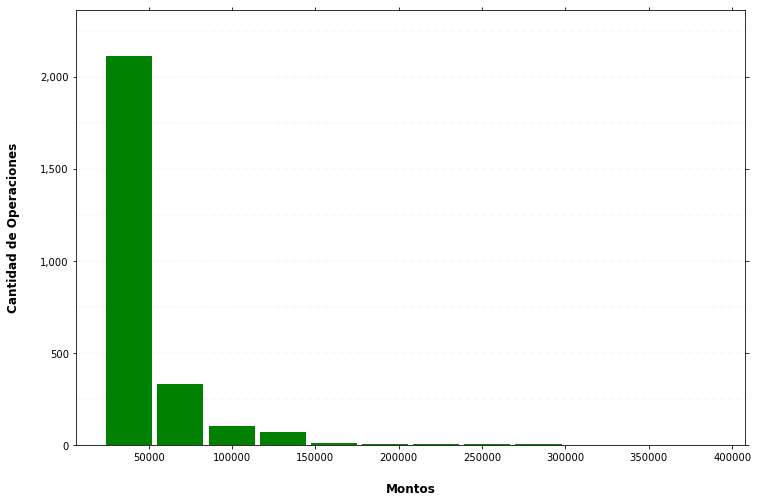

In [37]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_sal_grupo_sum_mul['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_sal_grupo_sum_mul_lim_excluir = df_trans_sal_grupo_sum_mul[df_trans_sal_grupo_sum_mul['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_sal_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_sal_grupo_sum_mul_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_sal_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_sal_grupo_sum_mul_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_sal_grupo_sum_mul_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_sal_grupo_sum_mul_lim_excluir_frec.index).value_counts()
df_trans_sal_grupo_sum_mul_lim_excluir_frec["Marca"]  = df_trans_sal_grupo_sum_mul_lim_excluir_frec.index.mid

display(df_trans_sal_grupo_sum_mul_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS SALIDAS OPERACIONES MULTIPLES***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
pd.options.display.float_format = '{:.2f}'.format

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_sal_grupo_sum_mul.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df_sal_mult{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df_sal_mult{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_sal_mul_{i}_excluir'] = locals()[f'df_sal_mult{i}'][locals()[f'df_sal_mult{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_sal_mul_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_sal_mul_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_sal_mul_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_sal_mul_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_sal_mul_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_sal_mul_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_sal_mul_{i}_frec_excluir']["Marca"]  = locals()[f'df_sal_mul_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_sal_mul_{i}_frec_excluir'])